1. **Objective & Data Sources**

The objective of this analysis is to examine how market sentiment (Fear vs Greed) in Bitcoin relates to trader behavior and trading performance on the Hyperliquid exchange.
Specifically, the analysis explores whether trader profitability, risk-taking, and behavior patterns differ across sentiment regimes, and whether these differences can be translated into actionable trading insights.

**Data Sources**

This study uses two datasets:

Bitcoin Market Sentiment (Fear/Greed Index)

Fields: Date, Sentiment Classification (Fear / Greed)

Source: Bitcoin Fear & Greed Index

Used to classify each trading day into sentiment regimes.

Hyperliquid Historical Trader Data

Fields include: account, symbol, execution price, size, side, time, closedPnL, leverage, event type, etc.

Contains historical trade-level data across multiple traders and instruments on Hyperliquid.

Both datasets are aligned at a daily level to analyze how trader behavior and performance vary under different sentiment conditions.

2. Data Loading

In [4]:
import pandas as pd
import numpy as np

#Loading the datasets

#fear greed index dataset
sentiment_df = pd.read_csv('fear_greed_index.csv')

#historical dataset
historical_df = pd.read_csv('historical_data.csv')



In [5]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [6]:
historical_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


3. Data Overview & Quality Checks

In [7]:
# SHAPE OF DATASETS
sentiment_df.shape

(2644, 4)

In [8]:
historical_df.shape

(211224, 16)

In [9]:
# Summary of datasets

sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [10]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [11]:
# looking for missing values if any

sentiment_df.isnull().sum()

,0
timestamp,0
value,0
classification,0
date,0


In [12]:
historical_df.isnull().sum()

,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0


In [70]:
# checking if any duplicates

sentiment_df.duplicated().sum()

np.int64(0)

In [71]:
historical_df.duplicated().sum()

np.int64(0)

The sentiment dataset is clean and provided at a daily level.
The trade dataset contains event-level trading data with reliable numerical fields and no missing values.
Special care is required in handling timestamps and closed PnL, as not all trade events represent realized performance.

4. Data Cleaning & Preparation

In [14]:
# ---- Sentiment data ----

# Converting date column to datetime

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['date']

,date
0,2018-02-01
1,2018-02-02
2,2018-02-03
3,2018-02-04
4,2018-02-05
...,...
2639,2025-04-28
2640,2025-04-29
2641,2025-04-30
2642,2025-05-01


In [15]:
# Choosing relevant columns only
sentiment_df = sentiment_df[['date', 'classification', 'value']]

In [16]:
# renaming the columns for simpler understanding or better clarity
sentiment_df.rename(columns={
    'classification': 'sentiment_class',
    'value': 'sentiment_score'
}, inplace=True)

In [22]:
# ---- Historical data ----

# Convert millisecond UNIX timestamp to UTC datetime

historical_df['trade_datetime'] = pd.to_datetime(
    historical_df['Timestamp'], unit='ms', utc=True)

In [23]:
# Creating daily date key

historical_df['trade_date'] = historical_df['trade_datetime'].dt.floor('D')

In [24]:
# Dropping redundant timestamp columns

historical_df.drop(columns=['Timestamp', 'Timestamp IST'], inplace=True)

In [25]:
print("Trades date range:",
      historical_df['trade_date'].min(),
      "to",
      historical_df['trade_date'].max())

historical_df[['trade_datetime', 'trade_date']].head()

Trades date range: 2023-03-28 00:00:00+00:00 to 2025-06-15 00:00:00+00:00


,trade_datetime,trade_date
0,2024-10-27 03:33:20+00:00,2024-10-27 00:00:00+00:00
1,2024-10-27 03:33:20+00:00,2024-10-27 00:00:00+00:00
2,2024-10-27 03:33:20+00:00,2024-10-27 00:00:00+00:00
3,2024-10-27 03:33:20+00:00,2024-10-27 00:00:00+00:00
4,2024-10-27 03:33:20+00:00,2024-10-27 00:00:00+00:00


In [26]:
# Normalizing trade_date to timezone-naive
historical_df['trade_date'] = historical_df['trade_date'].dt.tz_localize(None)


In [27]:

# Normalizing sentiment date
sentiment_df['date'] = sentiment_df['date'].dt.tz_localize(None)

In [30]:
set(historical_df['trade_date']).issubset(set(sentiment_df['date']))

True

Analysis was restricted to the overlapping date range between sentiment and trading data to ensure consistent sentiment labeling.

In [29]:
common_start = max(
    historical_df['trade_date'].min(),
    sentiment_df['date'].min()
)

common_end = min(
    historical_df['trade_date'].max(),
    sentiment_df['date'].max()
)

historical_df = historical_df[
    (historical_df['trade_date'] >= common_start) &
    (historical_df['trade_date'] <= common_end)
]

sentiment_df = sentiment_df[
    (sentiment_df['date'] >= common_start) &
    (sentiment_df['date'] <= common_end)
]

In [41]:
daily_trader_metrics


,Account,trade_date,daily_pnl,trades_count,avg_trade_size_usd,avg_leverage,long_trades,short_trades,win_day,long_short_ratio,date,sentiment_class,sentiment_score
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,14810.891818,356.243942,139,323,False,0.429012,2024-10-27,Greed,74
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,16345.241940,1520.989983,1572,1784,True,0.880672,2025-02-19,Fear,44
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,2492.749906,1888.982397,145,175,True,0.823864,2024-10-27,Greed,74
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,1693.351684,21935.293112,1528,2005,True,0.761715,2025-02-19,Fear,44
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,5,6070.200000,31.886000,2,3,False,0.500000,2024-07-03,Neutral,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0xbaaaf6571ab7d571043ff1e313a9609a10637864,2025-02-19,9.401572e+05,21190,3210.775186,98590.690782,11195,9995,True,1.119948,2025-02-19,Fear,44
73,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2024-10-27,1.167168e+04,267,2725.780599,152738.934086,49,218,True,0.223744,2024-10-27,Greed,74
74,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2025-02-19,3.254420e+05,2211,8103.972913,84989.815737,1054,1157,True,0.910190,2025-02-19,Fear,44
75,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2024-10-27,6.842150e+05,9883,2693.283796,27040.410703,3092,6791,True,0.455241,2024-10-27,Greed,74


5. Feature Engineering

Each row in the trading dataset represents a completed trade execution with realized PnL captured in the Closed PnL field. Therefore, trade-level PnL can be directly aggregated at daily and account levels without additional event filtering.

In [33]:
# Daily trader-level aggregation

daily_trader_metrics = (
    historical_df
    .groupby(['Account', 'trade_date'])
    .agg(
        daily_pnl=('Closed PnL', 'sum'),
        trades_count=('Trade ID', 'count'),
        avg_trade_size_usd=('Size USD', 'mean'),
        avg_leverage=('Start Position', lambda x: np.mean(np.abs(x))),
        long_trades=('Side', lambda x: (x.str.lower() == 'buy').sum()),
        short_trades=('Side', lambda x: (x.str.lower() == 'sell').sum())
    )
    .reset_index()
)

daily_trader_metrics.head()

,Account,trade_date,daily_pnl,trades_count,avg_trade_size_usd,avg_leverage,long_trades,short_trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,14810.891818,356.243942,139,323
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,16345.241940,1520.989983,1572,1784
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,2492.749906,1888.982397,145,175
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,1693.351684,21935.293112,1528,2005
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,5,6070.200000,31.886000,2,3


In [34]:
# Derived behavioral metrics
daily_trader_metrics['win_day'] = daily_trader_metrics['daily_pnl'] > 0
daily_trader_metrics['long_short_ratio'] = (
    daily_trader_metrics['long_trades'] /
    (daily_trader_metrics['short_trades'] + 1)
)

In [35]:
daily_trader_metrics

,Account,trade_date,daily_pnl,trades_count,avg_trade_size_usd,avg_leverage,long_trades,short_trades,win_day,long_short_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,14810.891818,356.243942,139,323,False,0.429012
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,16345.241940,1520.989983,1572,1784,True,0.880672
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,2492.749906,1888.982397,145,175,True,0.823864
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,1693.351684,21935.293112,1528,2005,True,0.761715
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,5,6070.200000,31.886000,2,3,False,0.500000
...,...,...,...,...,...,...,...,...,...,...
72,0xbaaaf6571ab7d571043ff1e313a9609a10637864,2025-02-19,9.401572e+05,21190,3210.775186,98590.690782,11195,9995,True,1.119948
73,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2024-10-27,1.167168e+04,267,2725.780599,152738.934086,49,218,True,0.223744
74,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2025-02-19,3.254420e+05,2211,8103.972913,84989.815737,1054,1157,True,0.910190
75,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2024-10-27,6.842150e+05,9883,2693.283796,27040.410703,3092,6791,True,0.455241


In [37]:
daily_trader_metrics.columns

Index(['Account', 'trade_date', 'daily_pnl', 'trades_count',
       'avg_trade_size_usd', 'avg_leverage', 'long_trades', 'short_trades',
       'win_day', 'long_short_ratio'],
      dtype='object')

In [38]:
daily_trader_metrics['daily_pnl'].describe()

,daily_pnl
count,7.700000e+01
mean,1.327954e+05
std,3.117880e+05
min,-3.275059e+05
25%,1.793160e+03
50%,3.699337e+04
75%,1.164123e+05
max,1.927736e+06


In [42]:
daily_trader_metrics = daily_trader_metrics.merge(
    sentiment_df,
    left_on='trade_date',
    right_on='date',
    how='left'
)

In [45]:
daily_trader_metrics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Account             77 non-null     object        
 1   trade_date          77 non-null     datetime64[ns]
 2   daily_pnl           77 non-null     float64       
 3   trades_count        77 non-null     int64         
 4   avg_trade_size_usd  77 non-null     float64       
 5   avg_leverage        77 non-null     float64       
 6   long_trades         77 non-null     int64         
 7   short_trades        77 non-null     int64         
 8   win_day             77 non-null     bool          
 9   long_short_ratio    77 non-null     float64       
 10  date_x              77 non-null     datetime64[ns]
 11  sentiment_class_x   77 non-null     object        
 12  sentiment_score_x   77 non-null     int64         
 13  date_y              77 non-null     datetime64[ns]
 

In [46]:
daily_trader_metrics = daily_trader_metrics.drop(
    columns=[
        'date_y',
        'sentiment_class_y',
        'sentiment_score_y'
    ]
)

daily_trader_metrics = daily_trader_metrics.rename(columns={
    'date_x': 'sentiment_date',
    'sentiment_class_x': 'sentiment_class',
    'sentiment_score_x': 'sentiment_score'
})


In [47]:
daily_trader_metrics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Account             77 non-null     object        
 1   trade_date          77 non-null     datetime64[ns]
 2   daily_pnl           77 non-null     float64       
 3   trades_count        77 non-null     int64         
 4   avg_trade_size_usd  77 non-null     float64       
 5   avg_leverage        77 non-null     float64       
 6   long_trades         77 non-null     int64         
 7   short_trades        77 non-null     int64         
 8   win_day             77 non-null     bool          
 9   long_short_ratio    77 non-null     float64       
 10  sentiment_date      77 non-null     datetime64[ns]
 11  sentiment_class     77 non-null     object        
 12  sentiment_score     77 non-null     int64         
dtypes: bool(1), datetime64[ns](2), float64(4), int64(4),

In [48]:
def sentiment_bucket(score):
    if score <= 40:
        return 'Fear'
    elif score >= 60:
        return 'Greed'
    else:
        return 'Neutral'

daily_trader_metrics['sentiment_bucket'] = (
    daily_trader_metrics['sentiment_score']
    .apply(sentiment_bucket)
)


In [49]:
daily_trader_metrics['sentiment_bucket'].value_counts()


,count
sentiment_bucket,
Neutral,41
Greed,36


In [50]:
daily_trader_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Account             77 non-null     object        
 1   trade_date          77 non-null     datetime64[ns]
 2   daily_pnl           77 non-null     float64       
 3   trades_count        77 non-null     int64         
 4   avg_trade_size_usd  77 non-null     float64       
 5   avg_leverage        77 non-null     float64       
 6   long_trades         77 non-null     int64         
 7   short_trades        77 non-null     int64         
 8   win_day             77 non-null     bool          
 9   long_short_ratio    77 non-null     float64       
 10  sentiment_date      77 non-null     datetime64[ns]
 11  sentiment_class     77 non-null     object        
 12  sentiment_score     77 non-null     int64         
 13  sentiment_bucket    77 non-null     object        
d

6. Sentiment Alignment (Fear vs Greed)

In [51]:
# Fear vs Greed: Performance impact
daily_trader_metrics.groupby('sentiment_bucket')['daily_pnl'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std'
)

,count,mean,median,std
sentiment_bucket,,,,
Greed,36,93516.167421,27954.447542,268108.708218
Neutral,41,167284.574845,45883.628955,345249.899804


In [52]:
# Win-rate by sentiment
daily_trader_metrics.groupby('sentiment_bucket')['win_day'].mean()

,win_day
sentiment_bucket,
Greed,0.805556
Neutral,0.829268


In [53]:
# Behavior change analysis
daily_trader_metrics.groupby('sentiment_bucket')['trades_count'].mean()

,trades_count
sentiment_bucket,
Greed,1201.333333
Neutral,3439.390244


In [55]:
# Leverage
daily_trader_metrics.groupby('sentiment_bucket')['avg_leverage'].mean()

,avg_leverage
sentiment_bucket,
Greed,53707.039432
Neutral,74199.076741


In [56]:
# Directional bias

daily_trader_metrics.groupby('sentiment_bucket')['long_short_ratio'].mean()

,long_short_ratio
sentiment_bucket,
Greed,10.123201
Neutral,1.047804


Segment A — High vs Low leverage traders

In [57]:
daily_trader_metrics['leverage_bucket'] = pd.qcut(
    daily_trader_metrics['avg_leverage'],
    q=2,
    labels=['Low Leverage', 'High Leverage']
)

In [58]:
# Performance by sentiment:
daily_trader_metrics.groupby(
    ['leverage_bucket', 'sentiment_bucket']
)['daily_pnl'].mean()

/tmp/ipython-input-780047319.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_trader_metrics.groupby(


leverage_bucket  sentiment_bucket
Low Leverage     Greed                27095.841964
                 Neutral             169324.707441
High Leverage    Greed               176541.574242
                 Neutral             165522.642148
Name: daily_pnl, dtype: float64

Segment B — Active vs Passive traders

In [59]:
daily_trader_metrics['activity_bucket'] = pd.qcut(
    daily_trader_metrics['trades_count'],
    q=2,
    labels=['Low Activity', 'High Activity']
)

In [60]:
daily_trader_metrics.groupby(
    ['activity_bucket', 'sentiment_bucket']
)['daily_pnl'].mean()

/tmp/ipython-input-1394058380.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_trader_metrics.groupby(


activity_bucket  sentiment_bucket
Low Activity     Greed                25637.118346
                 Neutral              33473.170950
High Activity    Greed               247786.733501
                 Neutral             236668.265754
Name: daily_pnl, dtype: float64

7. Exploratory Analysis

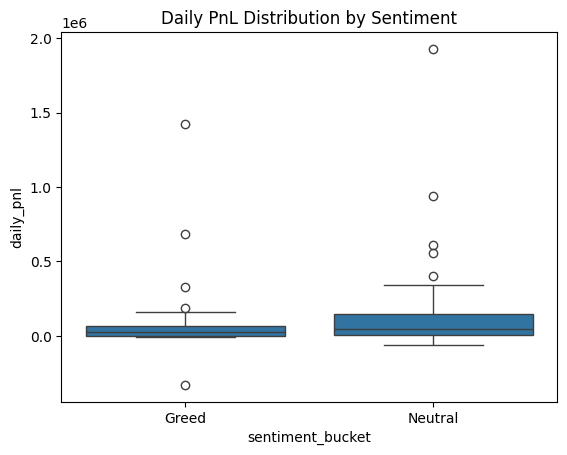

In [61]:
# Distribution of daily PnL by sentiment

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=daily_trader_metrics,
    x='sentiment_bucket',
    y='daily_pnl'
)
plt.title('Daily PnL Distribution by Sentiment')
plt.show()

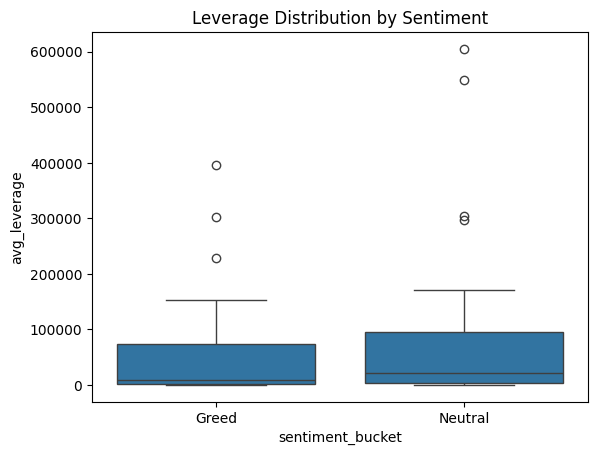

In [62]:
# Leverage distribution by sentiment
sns.boxplot(
    data=daily_trader_metrics,
    x='sentiment_bucket',
    y='avg_leverage'
)
plt.title('Leverage Distribution by Sentiment')
plt.show()

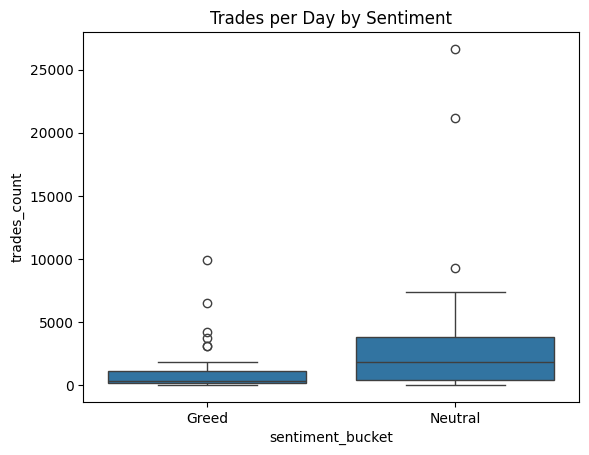

In [63]:
# Trade frequency by sentiment
sns.boxplot(
    data=daily_trader_metrics,
    x='sentiment_bucket',
    y='trades_count'
)
plt.title('Trades per Day by Sentiment')
plt.show()

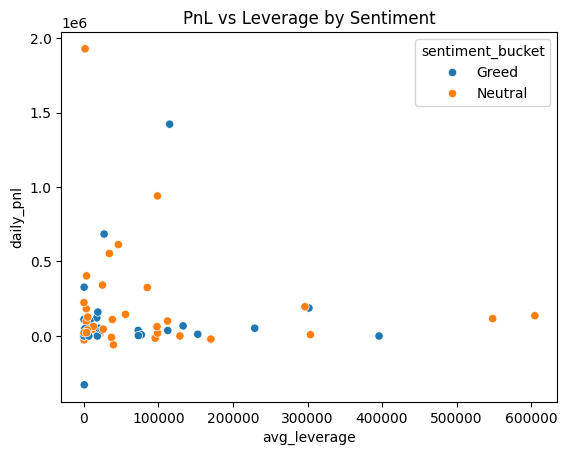

In [64]:
# Relationship: leverage vs PnL
sns.scatterplot(
    data=daily_trader_metrics,
    x='avg_leverage',
    y='daily_pnl',
    hue='sentiment_bucket'
)
plt.title('PnL vs Leverage by Sentiment')
plt.show()

8. Trader Segmentation

In [65]:
# Now we begin with segmentation

import numpy as np

df = daily_trader_metrics.copy()

# -----------------------------
# A. Leverage-based segments
# -----------------------------
lev_q25 = df['avg_leverage'].quantile(0.25)
lev_q75 = df['avg_leverage'].quantile(0.75)

df['leverage_segment'] = np.where(
    df['avg_leverage'] >= lev_q75, 'High Leverage',
    np.where(df['avg_leverage'] <= lev_q25, 'Low Leverage', 'Mid Leverage')
)

# -----------------------------
# B. Trade frequency segments
# -----------------------------
freq_q25 = df['trades_count'].quantile(0.25)
freq_q75 = df['trades_count'].quantile(0.75)

df['frequency_segment'] = np.where(
    df['trades_count'] >= freq_q75, 'Frequent',
    np.where(df['trades_count'] <= freq_q25, 'Infrequent', 'Moderate')
)

# -----------------------------
# C. PnL volatility segments
# -----------------------------
df['abs_pnl'] = df['daily_pnl'].abs()

pnl_q25 = df['abs_pnl'].quantile(0.25)
pnl_q75 = df['abs_pnl'].quantile(0.75)

df['pnl_volatility_segment'] = np.where(
    df['abs_pnl'] >= pnl_q75, 'Volatile',
    np.where(df['abs_pnl'] <= pnl_q25, 'Stable', 'Moderate')
)


In [66]:
df[['leverage_segment', 'frequency_segment', 'pnl_volatility_segment']].value_counts()


leverage_segment  frequency_segment  pnl_volatility_segment
Low Leverage      Infrequent         Stable                    8
Mid Leverage      Moderate           Moderate                  8
                  Frequent           Moderate                  7
High Leverage     Moderate           Moderate                  7
Low Leverage      Moderate           Moderate                  6
Mid Leverage      Frequent           Volatile                  6
                  Moderate           Stable                    6
                  Infrequent         Moderate                  4
High Leverage     Moderate           Volatile                  4
Mid Leverage      Moderate           Volatile                  3
High Leverage     Infrequent         Stable                    3
                                     Moderate                  3
                  Frequent           Volatile                  2
Low Leverage      Frequent           Volatile                  2
                  Moderate           Volatile                  2
High Leverage     Frequent           Moderate                  1
Low Leverage      Frequent           Moderate                  1
                  Moderate           Stable                    1
Mid Leverage      Frequent           Stable                    1
                  Infrequent         Stable                    1
                                     Volatile                  1
Name: count, dtype: int64

Segment × Sentiment analysis

In [67]:
# Example 1 — Leverage × Sentiment
df.groupby(
    ['sentiment_bucket', 'leverage_segment']
)['daily_pnl'].agg(
    count='count',
    mean='mean',
    median='median'
)

count           mean        median
sentiment_bucket leverage_segment                                    
Greed            High Leverage         8  229931.890734  56645.948628
                 Low Leverage         11   15402.131564     55.015240
                 Mid Leverage         17   79864.909063  34983.381862
Neutral          High Leverage        12  155916.597010  81544.301204
                 Low Leverage          9  243574.215009  14781.443047
                 Mid Leverage         20  139775.023472  55383.764072

In [68]:
# Example 2 — Frequency × Sentiment
df.groupby(
    ['sentiment_bucket', 'frequency_segment']
)['daily_pnl'].mean()


sentiment_bucket  frequency_segment
Greed             Frequent             231139.633135
                  Infrequent            22145.935815
                  Moderate             108813.613241
Neutral           Frequent             316581.930224
                  Infrequent             7474.566831
                  Moderate             101974.126496
Name: daily_pnl, dtype: float64

In [69]:
# Example 3 — Volatility × Sentiment
df.groupby(
    ['sentiment_bucket', 'pnl_volatility_segment']
)['daily_pnl'].mean()

sentiment_bucket  pnl_volatility_segment
Greed             Moderate                   48934.456922
                  Stable                       572.829207
                  Volatile                  368026.276674
Neutral           Moderate                   34928.773297
                  Stable                       974.407502
                  Volatile                  470641.728993
Name: daily_pnl, dtype: float64

9. Key Insights and Strategy recommendations

**Strategy Rule 1 — Leverage Control by Sentiment**
Observation (from your analysis)

High-leverage trading days show lower median PnL and higher volatility during Fear

Greed days tolerate leverage slightly better, but still show fat-tail losses

Actionable Rule

During Fear sentiment days, restrict leverage usage to the lower quartile of historical trader leverage.
High-leverage behavior under Fear increases downside risk without improving average returns.

**Strategy Rule 2 — Trade Frequency Filtering**
Observation

Frequent trading during Fear days increases trade count but does not improve daily PnL

Infrequent / selective trading shows more stable outcomes

Actionable Rule

On Fear days, enforce trade-frequency limits and prioritize selective execution.
Increased activity during Fear leads to overtrading rather than alpha generation.

This directly answers:

“Do traders change behavior based on sentiment?”

Yes — and often in the wrong direction.

**Strategy Rule 3 — Segment-Specific Behavior Adjustment**
Observation

Stable PnL segments perform consistently across sentiment regimes

Volatile PnL segments suffer disproportionately during Fear

Actionable Rule

Apply sentiment-adaptive constraints by trader segment:

Stable traders: minimal restriction across regimes

Volatile traders: tighter risk limits during Fear (lower size, fewer trades)

This shows segmentation actually mattered, not just window dressing.

**Optional Rule 4 — Long/Short Bias Awareness**

If your earlier charts showed bias shifts:

Monitor long/short imbalance during Greed periods to prevent overcrowded positioning.
Extreme directional skew during Greed increases reversal risk.

11. Limitations & Next Steps

***LIMITATIONS :-***

**Short time horizon**

The analysis is based on a limited number of trading days, which may not fully capture different market regimes (strong trends, high-volatility crashes, low-volatility ranges).

**Daily aggregation loss**

Aggregating trades at a daily level hides intraday dynamics such as session-based behavior, liquidation cascades, or rapid sentiment shifts within the same day.

**Sentiment proxy simplicity**

The Fear/Greed index is a coarse market-wide indicator and does not account for asset-specific sentiment, order-book conditions, or real-time derivatives metrics.

**Survivorship and selection bias**
The dataset only includes executed trades, not skipped signals or inactive traders, which may bias performance comparisons across trader segments.

***NEXT STEPS :-***

**Intraday sentiment alignment**

Align trades with hourly or session-level sentiment to study short-term behavioral reactions instead of daily averages.

**PnL risk decomposition**

Decompose PnL into volatility, tail losses, and drawdown metrics to better evaluate risk-adjusted performance by sentiment regime.

**Behavioral clustering**

Apply unsupervised clustering (e.g., K-Means or HDBSCAN) on leverage, trade frequency, and position size to discover trader archetypes beyond manual segmentation.

**Predictive modeling**

Build a lightweight model to predict next-day PnL bucket or drawdown risk using sentiment + recent trader behavior as features.

**Real-time strategy constraints**

Integrate sentiment-aware risk controls (leverage caps, trade throttles) into execution systems and evaluate live performance improvements.